In [74]:
from collections import defaultdict

import time
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup


In [75]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [77]:
df = pd.read_csv("../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [78]:
df.shape

(50000, 2)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


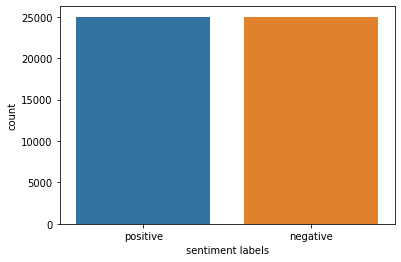

In [79]:
sns.countplot(df.sentiment)
plt.xlabel('sentiment labels');

In [80]:
df["sentiment"] = df["sentiment"].astype('category')
df["labels"] = df["sentiment"].cat.codes
df = df.drop(columns=['sentiment'])
df.head()

,review,labels
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [81]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Sample tokenization

In [82]:
sample_txt = """Loved today's show!!! It was a variety and not solely cooking (which would have been great too)."""
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Loved today's show!!! It was a variety and not solely cooking (which would have been great too).
   Tokens: ['loved', 'today', "'", 's', 'show', '!', '!', '!', 'it', 'was', 'a', 'variety', 'and', 'not', 'solely', 'cooking', '(', 'which', 'would', 'have', 'been', 'great', 'too', ')', '.']
Token IDs: [3866, 2651, 1005, 1055, 2265, 999, 999, 999, 2009, 2001, 1037, 3528, 1998, 2025, 9578, 8434, 1006, 2029, 2052, 2031, 2042, 2307, 2205, 1007, 1012]


### Special Tokens

In [83]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


### Sample encoding with special tokens

In [84]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [85]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [86]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 3866, 2651, 1005, 1055, 2265,  999,  999,  999, 2009, 2001, 1037,
        3528, 1998, 2025, 9578, 8434, 1006, 2029, 2052, 2031, 2042, 2307, 2205,
        1007, 1012,  102,    0,    0,    0,    0,    0])

In [87]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0]])

### Inverse Tokenization

In [88]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'loved',
 'today',
 "'",
 's',
 'show',
 '!',
 '!',
 '!',
 'it',
 'was',
 'a',
 'variety',
 'and',
 'not',
 'solely',
 'cooking',
 '(',
 'which',
 'would',
 'have',
 'been',
 'great',
 'too',
 ')',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing maximum token length

In [89]:
token_lens = []
for txt in df.review:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


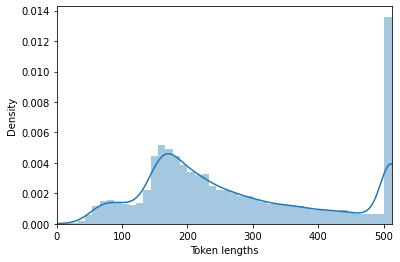

In [90]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token lengths');

In [91]:
del token_lens

In [92]:
MAX_LEN = 256

### Dataset Class

In [93]:
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        super().__init__()

        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)
    

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [94]:
df_train, df_val = train_test_split(
  df,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [95]:
df_train.shape, df_val.shape

((25000, 2), (25000, 2))

In [96]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = IMDBDataset(
        reviews=df.review.to_numpy(),
        labels=df.labels.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        dataset,
        batch_size=batch_size
    )

In [97]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

### Sample data

In [98]:
data = next(iter(train_data_loader))
data.keys()

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['review_text', 'input_ids', 'attention_mask', 'label'])

In [99]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


In [100]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [101]:
NUM_CLASSES = 2
model = SentimentClassifier(NUM_CLASSES)
model = model.to(device)
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [102]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [103]:
def train(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for index, batch in enumerate(data_loader):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    targets = batch["label"].to(device)

    # forward pass
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    # loss
    loss = loss_fn(outputs, targets)

    # accuracy
    _, preds = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    # backward pass
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # optimization
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    if index % 100 == 0:
        print(f"processed {index} batches")
  return correct_predictions.double() / n_examples, np.mean(losses)

In [104]:
def evaluation(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      targets = batch["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [105]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [106]:
torch.cuda.empty_cache()

In [107]:
history = defaultdict(list)
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()

    train_acc, train_loss = train(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    val_acc, val_loss = evaluation(model, val_data_loader, loss_fn, device, len(df_val))
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'model.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)


processed 0 batches
processed 100 batches
processed 200 batches
processed 300 batches
processed 400 batches
processed 500 batches
processed 600 batches
processed 700 batches
processed 800 batches
processed 900 batches
processed 1000 batches
processed 1100 batches
processed 1200 batches
processed 1300 batches
processed 1400 batches
processed 1500 batches
Epoch: 01 | Epoch Time: 20m 43s
	Train Loss: 0.277 | Train Acc: 88.92%
	 Val. Loss: 0.237 |  Val. Acc: 90.82%
processed 0 batches
processed 100 batches
processed 200 batches
processed 300 batches
processed 400 batches
processed 500 batches
processed 600 batches
processed 700 batches
processed 800 batches
processed 900 batches
processed 1000 batches
processed 1100 batches
processed 1200 batches
processed 1300 batches
processed 1400 batches
processed 1500 batches
Epoch: 02 | Epoch Time: 20m 41s
	Train Loss: 0.133 | Train Acc: 96.14%
	 Val. Loss: 0.316 |  Val. Acc: 91.81%
processed 0 batches
processed 100 batches
processed 200 batches
proc

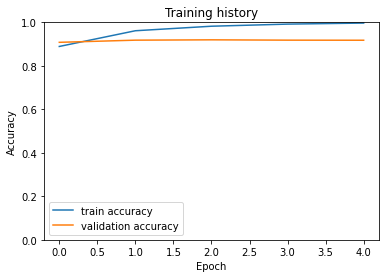

In [108]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [109]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [112]:
def inference(review_text, model, device):
    encoded_review = tokenizer.encode_plus(
        review_text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    print(f'Review text: {review_text}')
    print(f'Sentiment  : {prediction}')

In [113]:
test_review = "I really love the movie"
inference(test_review, model, device)

Review text: I really love the movie
Sentiment  : tensor([1], device='cuda:0')


In [114]:
test_review = "I hate this movie, it was boring"
inference(test_review, model, device)

Review text: I hate this movie, it was boring
Sentiment  : tensor([0], device='cuda:0')
